In [1]:
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
from sympy import *


def boys(n, x):
    if x == 0.0:
        y = Float(1 / (2*n+1))
    else:
        y = lowergamma(n+1/2, x) / (2 * Pow(x, (n + 1/2)))
    return float(y)

In [3]:
from scipy.interpolate import pade

In [4]:
def boys_taylor_coeffs(j, k_max=15):
    return Matrix(k_max, 1, lambda i, l: Pow(-1.0, i) / ((2*j + 2*i + 1) * factorial(i)))


#print(boys_taylor_coeffs(5))

p, q = pade([1./11, -0.0769230769230769, 0.0333333333333333, -0.00980392156862745, 0.00219298245614035, -0.000396825396825397, 6.03864734299517e-5, -7.93650793650794e-6, 9.18577307466196e-7, -9.50252387033996e-8], 5, 4)
print(p)
print(q)

           4           3            2
1.333e-05 x - 0.00037 x + 0.004614 x - 0.03042 x + 0.09091
           5            4           3          2
4.021e-05 x + 0.001133 x + 0.01514 x + 0.1169 x + 0.5115 x + 1


In [5]:
a = boys_taylor_coeffs(5, k_max=15)
a

Matrix([
[                 1/11],
[  -0.0769230769230769],
[   0.0333333333333333],
[ -0.00980392156862745],
[  0.00219298245614035],
[-0.000396825396825397],
[  6.03864734299517e-5],
[ -7.93650793650794e-6],
[  9.18577307466196e-7],
[ -9.50252387033996e-8],
[    8.889457814189e-9],
[ -7.5915479955884e-10],
[ 5.96478771081946e-11],
[ -4.3402821180599e-12],
[  2.9412168199307e-13]])

In [6]:
def _pade(an, m, n=None):
    
    if n is None:
        n = len(an) - 1 - m
        if n < 0:
            raise ValueError("Order of q <m> must be smaller than len(an)-1.")
            
    if n < 0:
        raise ValueError("Order of p <n> must be greater than 0.")
        
    N = m + n
    if N > len(an)-1:
        raise ValueError("Order of q+p <m+n> must be smaller than len(an).")
        
    an = Matrix(an[:N+1])
    Akj = eye(N+1, n+1)
    Bkj = zeros(N+1, m)
    
    for row in range(1, m+1):
        Bkj[row, :row] = [(an[:row])[::-1]]
        
    for row in range(m+1, N+1):
        Bkj[row,:] = [(an[row-m:row])[::-1]]
        
    C = Akj.row_join(-Bkj)
    pq = C.LUsolve(an)
    p = pq[:n+1]
    q = pq[n+1:]
    q.insert(0, Float(1.0))
    return p, q    

In [7]:
p, q = _pade(boys_taylor_coeffs(28, k_max=21), 15)
print(len(p))
print(len(q))

6
16


In [8]:
def pade_evalf(x, p, q):
    num = Float(0.0)
    for i, v in enumerate(p):
        num += v * Pow(x, i)
    den = 0.0    
    for i, v in enumerate(q):
        den += v * Pow(x, i)
    return (num/den).evalf(25)

In [9]:
def boys_pade(*, order, x, k_max=200, L=6, M=5):
    """
    L is the desired order for the denominator polynomial
    M is the desired order for the numerator polynomial
    """
    p, q = _pade(boys_taylor_coeffs(order, k_max=k_max), L, M)
    return pade_evalf(x, p, q)

In [10]:
boys_pade(order=5, x=0.89)

0.04312059308617916669748027

In [11]:
boys_pade(order=5, x=0.89, L=32, M=30)

0.04312059308618788194822358

In [12]:
#pades = [(5, 6), (5, 10), (9, 10), (10, 11), (12, 13), (5, 16), (15, 16), (30, 32)]
orders = [1, 2, 5, 10, 28]
coeffs = {k:boys_taylor_coeffs(k, k_max=200) for k in orders}
pades = {k: {
    (9, 10): _pade(coeffs[k], 10, 9),
    (10, 11): _pade(coeffs[k], 11, 10),
    (11, 12): _pade(coeffs[k], 12, 11),
    (12, 13): _pade(coeffs[k], 13, 12),
    (13, 14): _pade(coeffs[k], 14, 13),
    (14, 15): _pade(coeffs[k], 15, 14),
    (15, 16): _pade(coeffs[k], 16, 15), 
    #(30, 32): _pade(coeffs[k], 32, 30), 
    #(60, 64): _pade(coeffs[k], 64, 60),
    }
        for k in orders}

In [13]:
xs = np.arange(0.0, 14.0, 0.5)
lines = {}
for order, approximants in pades.items():
    exact = np.array([boys(order, x) for x in xs])
    for (M, L), (p, q) in approximants.items():
        approx = np.array([float(pade_evalf(x, p, q)) for x in xs])
        #print(f"{np.abs(exact - approx)=}, {-np.log10(np.abs(exact - approx))=}")
        lines[f"F_{order:02d} -log(|analytical - Padé [{M}/{L}]|)"] = -np.log10(np.abs(exact - approx))

/tmp/ipykernel_88/2816947098.py:8: RuntimeWarning: divide by zero encountered in log10
  lines[f"F_{order:02d} -log(|analytical - Padé [{M}/{L}]|)"] = -np.log10(np.abs(exact - approx))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
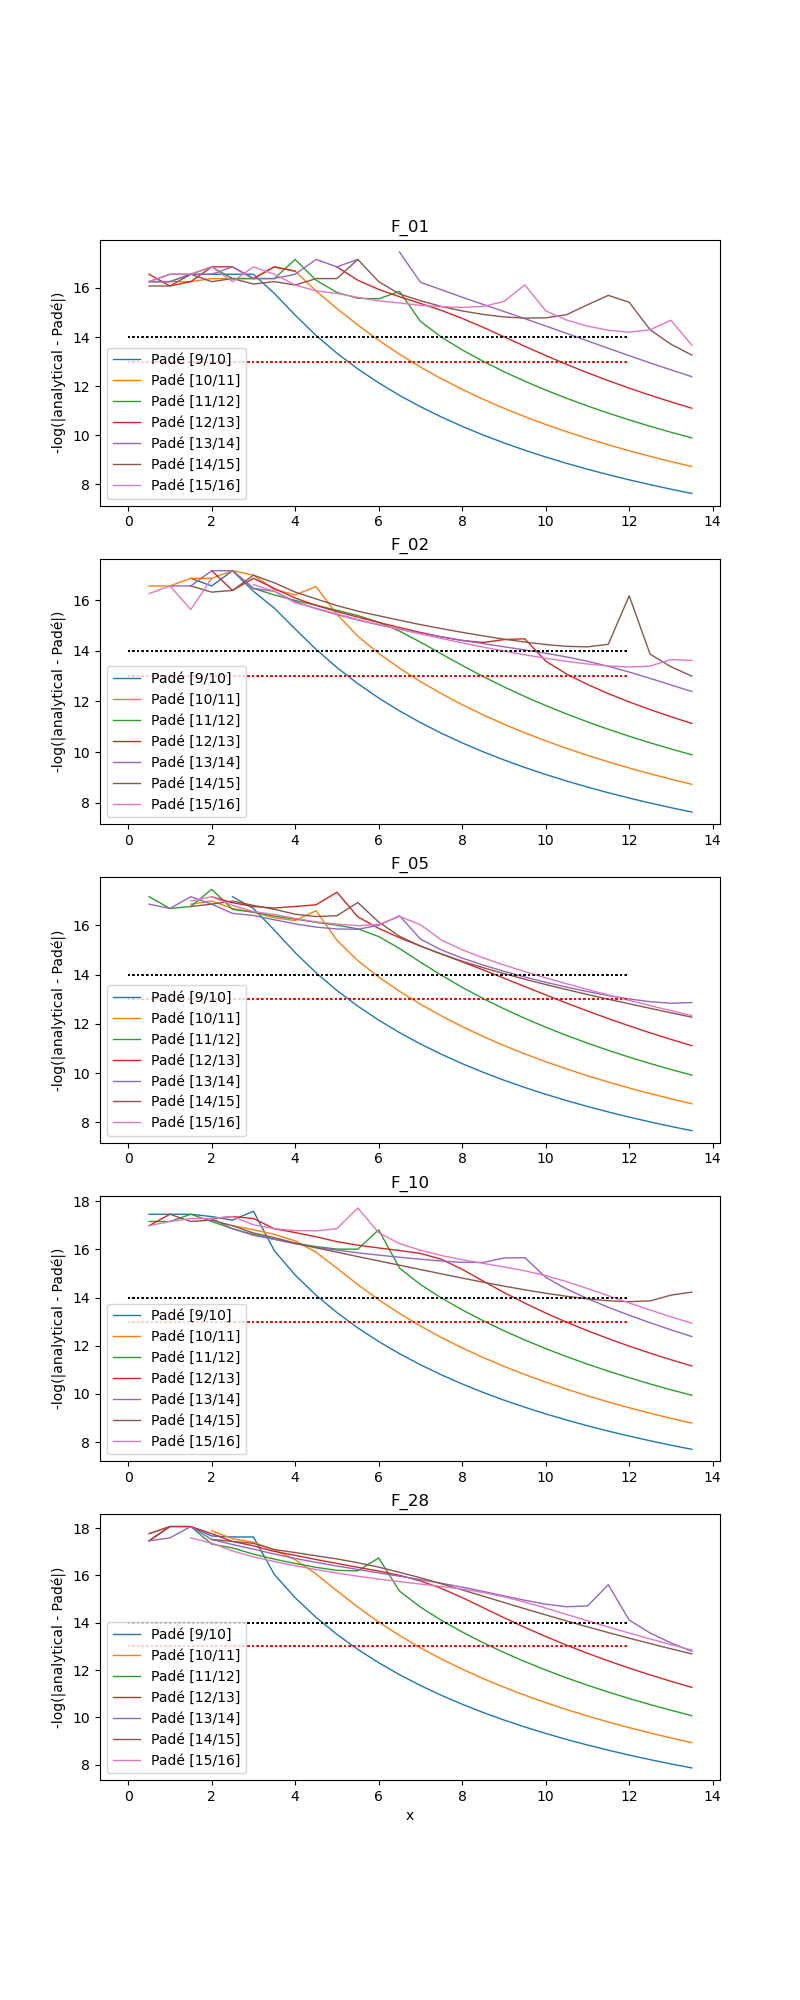

In [17]:
fig, axes = plt.subplots(5, 1, sharex=False, figsize=(8, 20))

idx = 0
for order in orders:
    for M, L in pades[order].keys():
        key = f"F_{order:02d} -log(|analytical - Padé [{M}/{L}]|)"
        axes[idx].plot(xs, lines[key], label=f"Padé [{M}/{L}]", linewidth=1)
        axes[idx].set_title(f"F_{order:02d}")
        axes[idx].set_ylabel(f"-log(|analytical - Padé|)")
        axes[idx].legend()
        axes[idx].hlines(13, 0.0, 12.0, color='red', linestyle='dotted', linewidth=1.25)
        axes[idx].hlines(14, 0.0, 12.0, color='black', linestyle='dotted', linewidth=1.25)
    idx += 1
axes[-1].set_xlabel("x")
plt.show()

In [15]:
inps = np.arange(0.0, 1000.0, 0.5)
zero = {}
for order in range(0, 33):
    for i, x in enumerate(inps):
        y = boys(order, x)
        if y <= 1e-14:
            zero[order] = i
            break

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
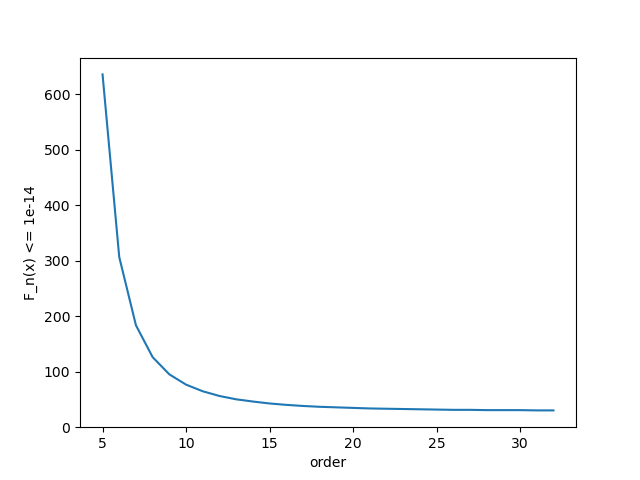

In [16]:
fig, ax = plt.subplots(1, 1)
ax.plot(zero.keys(), np.take(inps, list(zero.values())))
ax.set_xlabel("order")
ax.set_ylabel("F_n(x) <= 1e-14")
plt.show()